# Neural Style Transfer

The paper of Neural Style Transfer presented by Gatys demonstrates a remarkable characteristic of Deep Convolutional Neural Networks. It is a slow iterative process. This implementation is based on the same paper.

## Imports

In [34]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [33]:
import numpy as np
from PIL import Image
import time
import functools
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False



We enable eager execution on tensorflow

In [35]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


We now set up global values for image paths

In [41]:
content_path = 'data/raw/content.jpg'
style_path = 'data/raw/style.jpg'

In [42]:
# The image needs to be broadcasted to keep batch dimension
def image_load(path_to_image):
    max_dim = 512
    img = Image.open(path_to_image)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

In [43]:
# We remove the batch dimention and normalize the image for display
def imageshow(img, title=None):
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imageshow(out)
    if title is not None:
        plt.title(title)
    plt.imageshow(out)

## Visualizing the input images

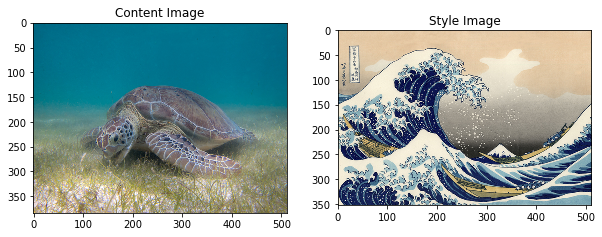

In [44]:
plt.figure(figsize=(10,10))
content = image_load(content_path).astype('uint8')
style = image_load(style_path).astype('uint8')
plt.subplot(1, 2, 1)
imageshow(content, 'Content Image')
plt.subplot(1, 2, 2)
imageshow(style, 'Style Image')
plt.show()

In [45]:
#  VGG networks are trained on image with each channel normalized by mean
#  we are using the network architecture VGG19
#  VGG19 is a pretrained image classification network
def process_and_load_image(path_to_image):
    img = image_load(path_to_image)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [46]:
#This is an inverse preprocessing step where we clip the image
def deprocess_image(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image function bmust be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Define content and style representation

The intermediate layers are necessary to define the representation of content and style from our images.
We try to match the corresponding style and content target representations at these intermediate layers.

In [47]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [48]:
# we load VGG19, and feed in our input tensor to the model
# This allows us to extract the feature maps of the content, style, and generated images
# These layers will then be used to create a new model that will take input image
#  and return the outputs from these intermediate layers from the VGG model. 
def get_model_vgg():
  
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return models.Model(vgg.input, model_outputs)

## Computing our Content Loss

In [49]:
def get_vgg_content_loss(base_content, target):
    vgg_content_loss = tf.reduce_mean(tf.square(base_content - target))
    return vgg_content_lossent_loss

In [50]:
# Obtain gram matrix
def get_gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    gram_val = gram / tf.cast(n, tf.float32)
    return gram_val

In [ ]:
# Obtain style loss
def get_vgg_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = get_gram_matrix(base_style)
    vgg_style_loss = tf.reduce_mean(tf.square(gram_style - gram_target))
    return vgg_style_loss

In [51]:
def get_feature_representations(model, content_path, style_path):
  
    content_image = process_and_load_image(content_path)
    style_image = process_and_load_image(style_path)
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [52]:
def get_total_loss(model, loss_weights, init_image, gram_style_features, content_features):
  
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score_total = 0
    content_score = 0
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score_total += weight_per_style_layer * get_vgg_style_loss(comb_style[0], target_style)
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_vgg_content_loss(comb_content[0], target_content)
    style_score_total *= style_weight
    content_score *= content_weight
    loss = style_score_total + content_score 
    return loss, style_score_total, content_score

In [54]:
def compute_gradient(config):
    with tf.GradientTape() as tape: 
        all_loss = get_total_loss(**config)
    total_loss = all_loss[0]
    gradient = tape.gradient(total_loss, config['init_image'])
    return gradient, all_loss

## Implementing the model

In [58]:
import IPython.display

def implement_neural_style_transfer(content_path, 
                       style_path,
                       num_iterations=500,
                       content_weight=1e3, 
                       style_weight=1e-3): 
  
    model = get_model_vgg() 
    for layer in model.layers:
        layer.trainable = False
  
    # Obtain style and contaent features
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [get_gram_matrix(style_feature) for style_feature in style_features]
  
    
    init_image = process_and_load_image(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    
    iter_count = 1

    
    final_loss, final_img = float('inf'), None

 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }
    
    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
  imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()

            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return final_img, final_loss

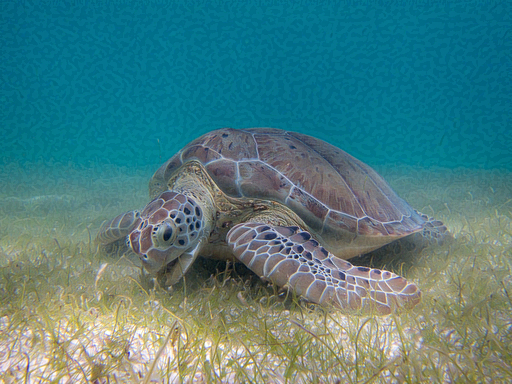

Iteration: 0
Total loss: 5.7769e+08, style loss: 5.7769e+08, content loss: 0.0000e+00, time: 0.6340s


In [ ]:
final, final_loss = implement_neural_style_transfer(content_path, 
                                     style_path, num_iterations=200)

## References

* Gatys, L. A., Ecker, A. S., Bethge, M., Hertzmann, A., & Shechtman, E. (2017). Controlling perceptual factors in neural style transfer. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 3985-3993).
* https://towardsdatascience.com/towards-fast-neural-style-transfer-191012b86284
* https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow
* https://github.com/tensorflow/models
